# Exercise 5
## Regularized Linear Regression and Bias v.s. Variance

## Regularized Linear Regression
### Visualizing the dataset

In [450]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.io import loadmat
from scipy import optimize
sns.set()

In [451]:
print(os.listdir())

['ex5.m', 'ex5data1.mat', 'exercise5.aux', 'exercise5.fdb_latexmk', 'exercise5.fls', 'exercise5.ipynb', 'exercise5.log', 'exercise5.out', 'exercise5.pdf', 'exercise5.synctex.gz', 'exercise5.tex', 'featureNormalize.m', 'fmincg.m', 'learningCurve.m', 'learningcurve.png', 'lib', 'linearfit.png', 'linearRegCostFunction.m', 'plotFit.m', 'polycurve1.png', 'polyFeatures.m', 'polyfit1.png', 'polyfit100.png', 'polylearningcurve.png', 'polynomialfit.png', 'scatter.png', 'selectlambda.png', 'submit.m', 'trainLinearReg.m', 'validationCurve.m']


In [452]:
data = loadmat('ex5data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [453]:
X = data['X']
y = data['y']
Xtest, ytest = data['Xtest'], data['ytest']
Xval, yval = data['Xval'], data['yval']
print(f'X, y: {X.shape}, {y.shape}')
print(f'Xtest, ytest: {Xtest.shape}, {ytest.shape}')
print(f'Xval, yval: {Xval.shape}, {yval.shape}')

X, y: (12, 1), (12, 1)
Xtest, ytest: (21, 1), (21, 1)
Xval, yval: (21, 1), (21, 1)


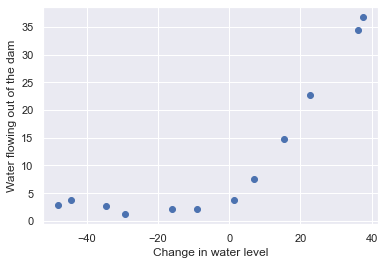

In [454]:
plt.scatter(X,y)
plt.xlabel('Change in water level')
plt.ylabel('Water flowing out of the dam')
plt.show()

### Regularized linear regression cost function

In [455]:
def linearRegCostFunction(X, y, theta, Lambda):
    m = len(y)
    y = y.reshape(m,1)
    grad = np.zeros(theta.shape)
    n_1 = theta.shape[0]
    theta = theta.reshape(n_1,1)
    cost = 0
    h = np.dot(X, theta)
    cost = 1/(2*m) * np.sum((h-y)**2)
    cost_reg = cost + Lambda/(2*m)*np.sum(theta[1:]**2)

    
    # grad = (1/m) * np.dot(X.T, h-y)
    # grad[1:,:] = grad[1:,:] + (Lambda/m) * theta[1:]

    grad[0] = (1/m)*(X[:,0:1].reshape(m,1)*(h - y)).sum(axis=0)
    grad[1:] = (1/m)*( (X[:,1:]*(h - y)).sum(axis=0)  + Lambda*theta[1:].reshape(n_1-1))

    return cost_reg, grad

In [456]:
m = X.shape[0]
X_1 = np.hstack((np.ones((m,1)), X))
# theta = np.ones((2,1))
theta = np.array([1, 1])
cost, grad = linearRegCostFunction(X_1, y, theta, 1)
print(f'Cost at theta = [1,1]:\t{cost:.6f}')
print(f'Value should be about 303.993192\n')
print(f'Gradient at theta = [1,1]:\n{grad}')
print(f'Value should be about\n[-15.30, 598.250]')

Cost at theta = [1,1]:	303.993192
Value should be about 303.993192

Gradient at theta = [1,1]:
[-15.30301567 598.25074417]
Value should be about
[-15.30, 598.250]


In [457]:
def trainLinearReg(linearRegCostFunction, X, y, Lambda=0, maxiter=200):

    initial_theta = np.zeros(X.shape[1])
    costFunction = lambda t: linearRegCostFunction(X, y, t, Lambda)
    options = {'maxiter': maxiter}
    minimizef = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return minimizef.x 

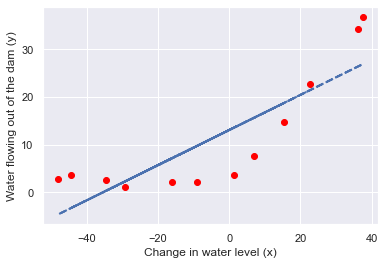

In [458]:
theta_optimized = trainLinearReg(linearRegCostFunction, X_1, y.flatten())

plt.scatter(X, y, c='red')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X, np.dot(X_1, theta_optimized), '--', lw=2)
plt.show()

## Bias-variance
### Learning curves

In [459]:
def learningCurve(X, y, Xval, yval, Lambda=0):
    m = len(y)
    training_error = np.zeros(m)
    validation_error = np.zeros(m)

    for i in range(m):
        theta_optimized1 = trainLinearReg(linearRegCostFunction, X[:i+1], y[:i+1], Lambda)
        training_error[i], _ = linearRegCostFunction(X[:i+1], y[:i+1], theta_optimized1, Lambda)
        validation_error[i], _ = linearRegCostFunction(Xval, yval, theta_optimized1, Lambda)

    return training_error, validation_error

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368911
  	5		13.154049	35.865165
  	6		19.443963	33.829961
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


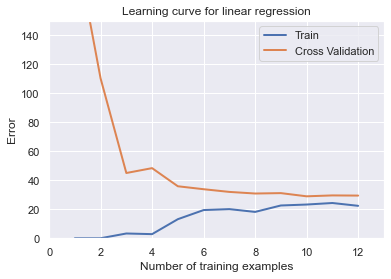

In [460]:
n = Xval.shape[0]
Xval_1 = np.hstack((np.ones((n,1)), Xval))
error_train, error_val = learningCurve(X_1, y.flatten(), Xval_1, yval.flatten())

m = y.size
plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

### Learning Polynomial Regression

In [461]:
def polyFeatures(X, p):
    m = X.shape[0]
    X_out = np.zeros((m,p))
    for i in range(p):
        X_out[:,i] = X.flatten()**(i+1)
    return X_out

In [462]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

In [463]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
m = X.shape[0]
X_poly = np.hstack((np.ones((m,1)), X_poly))

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.hstack((np.ones((Xtest.shape[0],1)), X_poly_test))

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.hstack((np.ones((Xval.shape[0],1)), X_poly_val))

print('Normalized Training Example 1:')
X_poly[0, :]

Normalized Training Example 1:


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

In [464]:
theta_optimized_poly = trainLinearReg(linearRegCostFunction, X_poly, y.flatten(), Lambda=0, maxiter=55)
theta_optimized_poly.shape

(9,)

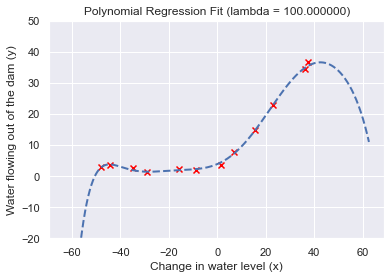

In [465]:
plt.scatter(X, y, c='red', marker='x')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

x_value = np.arange(np.min(X) - 15, np.max(X) + 25, 0.05).reshape(-1, 1)
x_value_poly = polyFeatures(x_value, p=8)
x_value_poly -= mu
x_value_poly /= sigma

m = x_value_poly.shape[0]
x_value_poly = np.hstack((np.ones((m,1)), x_value_poly))
y_value = np.dot(x_value_poly, theta_optimized_poly)

plt.plot(x_value, y_value, '--', lw=2)
plt.title('Polynomial Regression Fit (lambda = %f)' % Lambda)
plt.ylim([-20, 50])
plt.show()

In [466]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, Lambda=0)

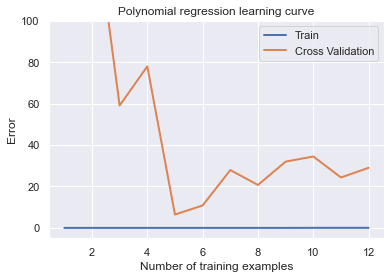

In [467]:
m = y.size
plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Polynomial regression learning curve')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.ylim([-5, 100])
plt.show()

### Adjusting the regularization parameter

Lambda = 1

In [468]:
Lambda = 1
theta_optimized_poly_1 = trainLinearReg(linearRegCostFunction, X_poly, y.flatten(), Lambda=Lambda, maxiter=55)
theta_optimized_poly_1.shape

(9,)

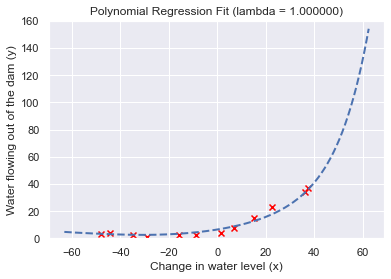

In [469]:
plt.scatter(X, y, c='red', marker='x')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

x_value = np.arange(np.min(X) - 15, np.max(X) + 25, 0.05).reshape(-1, 1)
x_value_poly = polyFeatures(x_value, p=8)
x_value_poly -= mu
x_value_poly /= sigma

m = x_value_poly.shape[0]
x_value_poly = np.hstack((np.ones((m,1)), x_value_poly))
y_value = np.dot(x_value_poly, theta_optimized_poly_1)

plt.plot(x_value, y_value, '--', lw=2)
plt.title('Polynomial Regression Fit (lambda = %f)' % Lambda)
plt.ylim([0, 160])
plt.show()

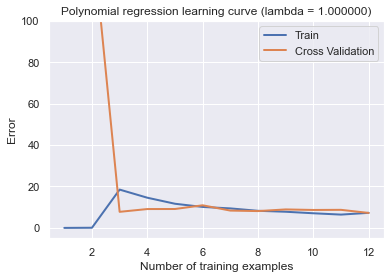

In [470]:
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, Lambda=Lambda)
m = y.size
plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Polynomial regression learning curve (lambda = %f)' % Lambda)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.ylim([-5, 100])
plt.show()

Lambda = 100

In [471]:
Lambda = 100
theta_optimized_poly_100 = trainLinearReg(linearRegCostFunction, X_poly, y.flatten(), Lambda=Lambda, maxiter=55)
theta_optimized_poly_100.shape

(9,)

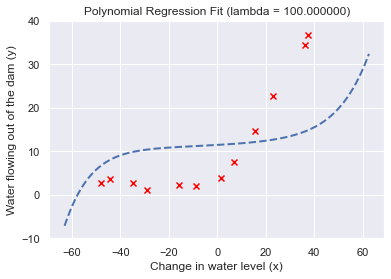

In [472]:
plt.scatter(X, y, c='red', marker='x')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

x_value = np.arange(np.min(X) - 15, np.max(X) + 25, 0.05).reshape(-1, 1)
x_value_poly = polyFeatures(x_value, p=8)
x_value_poly -= mu
x_value_poly /= sigma

m = x_value_poly.shape[0]
x_value_poly = np.hstack((np.ones((m,1)), x_value_poly))
y_value = np.dot(x_value_poly, theta_optimized_poly_100)

plt.plot(x_value, y_value, '--', lw=2)
plt.title('Polynomial Regression Fit (lambda = %f)' % Lambda)
plt.ylim([-10, 40])
plt.show()

### Selecting lambda using a cross validation set

In [473]:
def validationCurve(X, y, Xval, yval):
    
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    training_error = np.zeros(len(lambda_vec))
    validation_error = np.zeros(len(lambda_vec))

    for i in range(len(lambda_vec)):
        lambda_try = lambda_vec[i]
        theta_t = trainLinearReg(linearRegCostFunction, X, y, Lambda = lambda_try)
        training_error[i], _ = linearRegCostFunction(X, y, theta_t, Lambda = 0)
        validation_error[i], _ = linearRegCostFunction(Xval, yval, theta_t, Lambda = 0)

    return lambda_vec, training_error, validation_error

lambda		Train Error	Validation Error
 0.000000	0.033826	29.017273
 0.001000	0.112714	9.855996
 0.003000	0.170879	16.288684
 0.010000	0.221434	16.943267
 0.030000	0.281874	12.829051
 0.100000	0.459323	7.586721
 0.300000	0.921770	4.636772
 1.000000	2.076200	4.260600
 3.000000	4.901373	3.822909
 10.000000	16.092273	9.945554


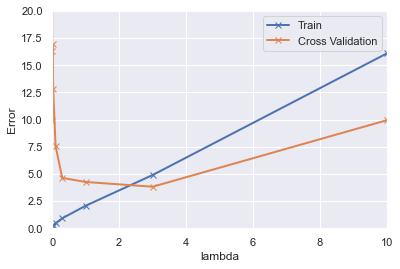

In [474]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, '-x', lambda_vec, error_val, '-x', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('lambda')
plt.ylabel('Error')
plt.ylim(0,20)
plt.xlim(0,10)

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))
